# TP Kalman Filter - Car Tracking

#### Maxence Durieu, Rali Benjelloun et Matthieu Monnot

In [2]:
import numpy as np
import matplotlib.pyplot as plt

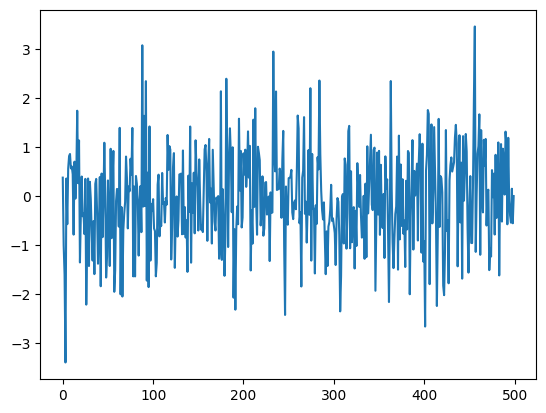

In [3]:
# On génère et on plot un bruit blanc gaussien grâce à la fonction suivante
def generate_white_gaussian_noise(mean, std, num_samples):
    samples = np.random.normal(mean, std, size=num_samples)
    plt.plot(samples)
    plt.show()
# Le bruit généré est de moyenne nulle, d'écart-type 1 et d'échantillon 500
generate_white_gaussian_noise(0, 1, 500)

## Données simulées

Dans cette partie nous allons nous intéresser à la simulation des données grâce à la position en coordonées cartésiennes d'un objet estimée par un capteur. On ajoute également un bruit blanc à ces données pour modéliser l'incertitude liée à la précision du capteur. 

In [4]:
# Echantillonage de 300 points et de 0.1 seconde
N = 300
dt = 0.1

In [5]:
# Fonction qui simule toutes les positions des états inférieurs à t
def state_system(t):
    A = [[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]]
    mean = [0, 0, 1, -1]
    cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
    mean2 = [0, 0, 0, 0]
    cov2 = [[(dt**3)/3, 0, (dt**2)/2, 0], [0, (dt**3)/3, 0, (dt**2)/2], [(dt**2)/2, 0, dt, 0], [0, (dt**2)/2, 0, dt]]
    # Initialisation avec les conditions initiales implémentées juste au dessus 
    L = [np.random.multivariate_normal(mean, cov, 1).T]
    # Pour chaque instant on calcule la position du nouveau point en fonction de la position précédente
    for i in range(1, t):
        L.append(np.dot(A, L[i-1]) + np.random.multivariate_normal(mean2, cov2, 1).T)
    # On renvoie une liste de ces positions dans l'ordre temporel
    return L
#state_system(N)

In [6]:
# On définie une fonction qui renvoie les positions antérieures à un certain temps t et ces mêmes
# positions avec un bruit blanc supplémentaire.
X1, Y1, X2, Y2, X3, X4, V1, V2 = [], [], [], [], [], [], [], []
mean = [0, 0]
cov = [[4, 0], [0, 4]]
# On génère les N états de la position
L = state_system(N)
for i in range(len(L)):
    # x est un vecteur avec la position et la vitesse de l'object
    # y est x avec un bruit blanc de moyenne 'mean' et de covariance 'cov'
    x,y = L[i], L[i][0:2] + np.random.multivariate_normal(mean, cov, 1).T

    # Pour chaque état on tire :

    # La position 
    X1.append(x[0])
    X2.append(x[1])

    # La vitesse
    X3.append(x[2])
    X4.append(x[3])

    # La position bruitée
    Y1.append(y[0])
    Y2.append(y[1])

    # La vitesse estimée par la méthode d'Euler
    V1.append((Y1[i]-Y1[i-1])/dt)
    V2.append((Y2[i]-Y2[i-1])/dt)

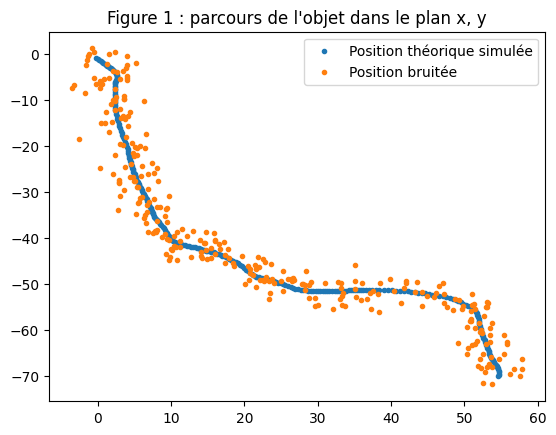

In [7]:
plt.plot(X1,X2,'.', label='Position théorique simulée')
plt.plot(Y1,Y2, '.', label='Position bruitée')
plt.title("Figure 1 : parcours de l'objet dans le plan x, y")
plt.legend()
plt.show()

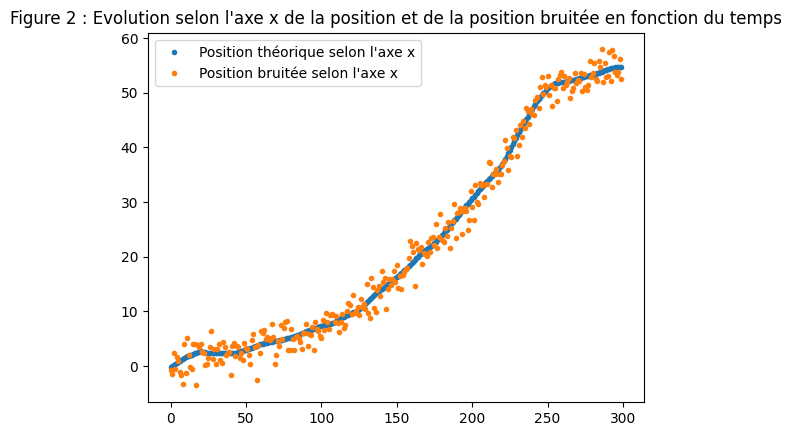

In [8]:
plt.plot(X1, '.', label="Position théorique selon l'axe x") 
plt.plot(Y1, '.', label="Position bruitée selon l'axe x")
plt.title("Figure 2 : Evolution selon l'axe x de la position et de la position bruitée en fonction du temps")
plt.legend()
plt.show()

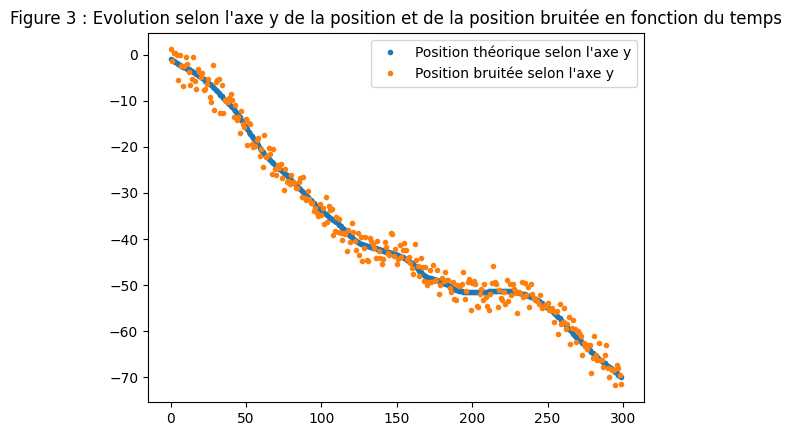

In [9]:
plt.plot(X2, '.', label="Position théorique selon l'axe y") 
plt.plot(Y2, '.', label="Position bruitée selon l'axe y")
plt.title("Figure 3 : Evolution selon l'axe y de la position et de la position bruitée en fonction du temps")
plt.legend()
plt.show()

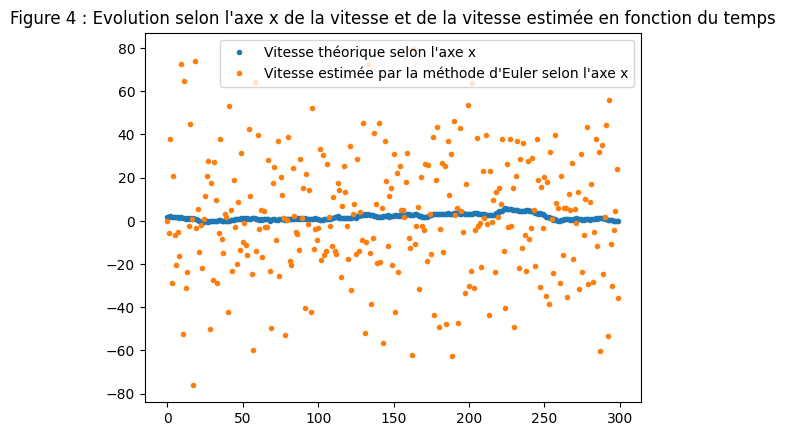

In [10]:
plt.plot(X3,'.', label="Vitesse théorique selon l'axe x") 
plt.plot(V1,'.', label="Vitesse estimée par la méthode d'Euler selon l'axe x")
plt.title("Figure 4 : Evolution selon l'axe x de la vitesse et de la vitesse estimée en fonction du temps")
plt.legend()
plt.show()

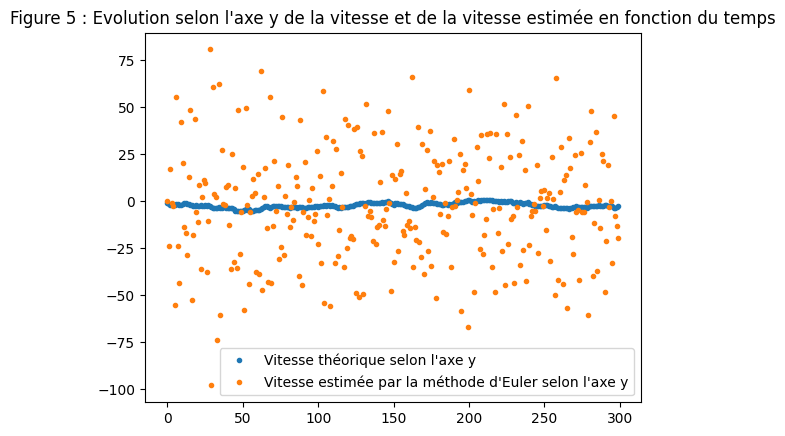

In [11]:
plt.plot(X4,'.', label="Vitesse théorique selon l'axe y") 
plt.plot(V2,'.', label="Vitesse estimée par la méthode d'Euler selon l'axe y")
plt.title("Figure 5 : Evolution selon l'axe y de la vitesse et de la vitesse estimée en fonction du temps")
plt.legend()
plt.show()

## Kalman filter

Dans cette partie on s'intéresser à la réalisation d'un filtre de Kalman pour approcher la position réelle théorique de l'objet même avec la présence d'un bruit dû à la précision du capteur

In [12]:
from dataclasses import dataclass
import time

# Initialisation des données 
dt = 0.1
A = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = [[4, 0], [0, 4]]
Q = [[(dt**3)/3, 0, (dt**2)/2, 0], [0, (dt**3)/3, 0, (dt**2)/2], [(dt**2)/2, 0, dt, 0], [0, (dt**2)/2, 0, dt]]

# On simule les données comme dans la partie précédente 
t = 100
W = state_system(t)
mean = [0, 0, 1, -1]

x0 = np.array([1, 0, 1, 0]).reshape(4,1)
m0 = x0
P0 = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
I = P0

Xe = []
Pe = []

for i in range(1, t):
    # Pour chaque état généré on ajoute un bruit blanc gaussien de moyenne 'mean' et de covariance 'P0'
    Y = W[i][0:2] + np.random.multivariate_normal(mean, P0, 1)

    # Phase de prédiction
    xp = np.dot(A,x0)
    Pp = np.dot(A,np.dot(P0,A.T))+Q

    # Phase de correction
    S = np.dot(C,np.dot(Pp,C.T))+R
    K = np.dot(np.dot(Pp,C.T),np.linalg.inv(S))
    xc = xp + np.dot(K,Y-np.dot(C,xp))
    Pc = np.dot(I-np.dot(K,C),Pp)
    
    # On stocke les valeurs générées
    Xe.append(xc)
    Pe.append(Pc)

    # On initialise la prochaine itération avec les valeurs trouvées
    x0 = xc
    P0 = Pc

In [13]:
P1_corr=[z[0] for z in Xe]
P2_corr=[z[1] for z in Xe]
P3_corr=[z[2] for z in Xe]
P4_corr=[z[3] for z in Xe]

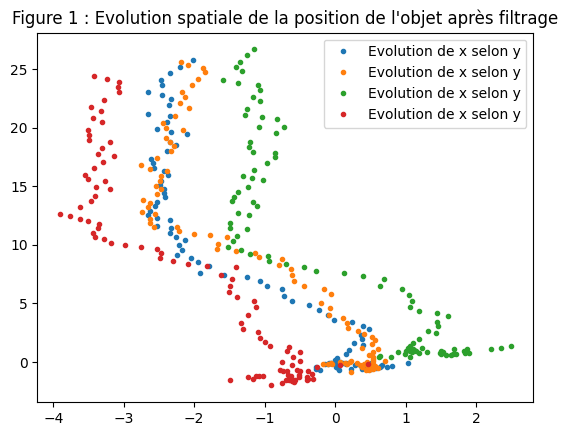

In [14]:
plt.plot(P1_corr, P2_corr, '.', label="Evolution de x selon y")
plt.title("Figure 1 : Evolution spatiale de la position de l'objet après filtrage")
plt.legend()
plt.show()

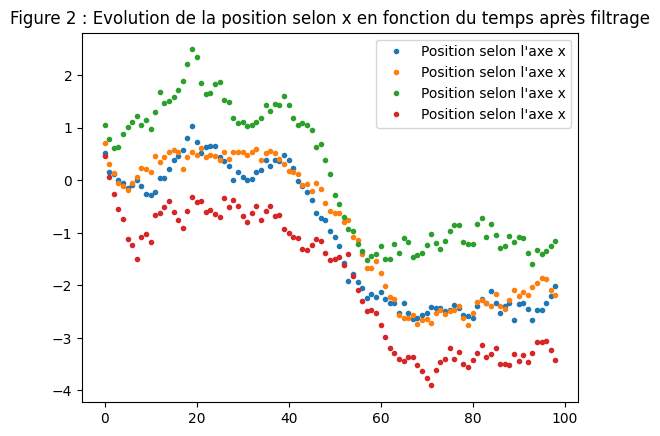

In [15]:
plt.plot(P1_corr, '.', label="Position selon l'axe x")
plt.title("Figure 2 : Evolution de la position selon x en fonction du temps après filtrage")
plt.legend()
plt.show()

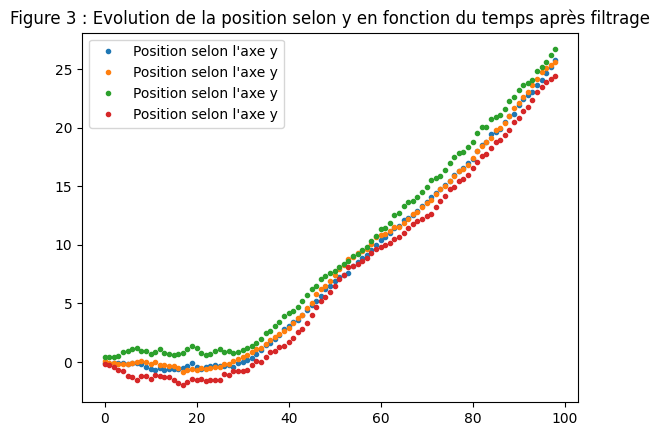

In [16]:
plt.plot(P2_corr, '.', label="Position selon l'axe y")
plt.title("Figure 3 : Evolution de la position selon y en fonction du temps après filtrage")
plt.legend()
plt.show()

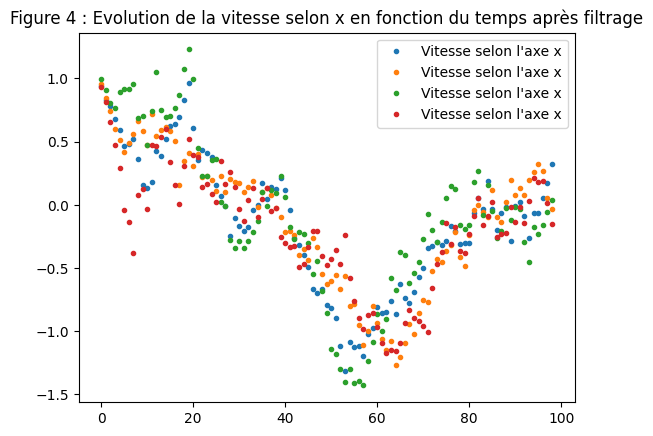

In [17]:
plt.plot(P3_corr, '.', label="Vitesse selon l'axe x")
plt.title("Figure 4 : Evolution de la vitesse selon x en fonction du temps après filtrage")
plt.legend()
plt.show()

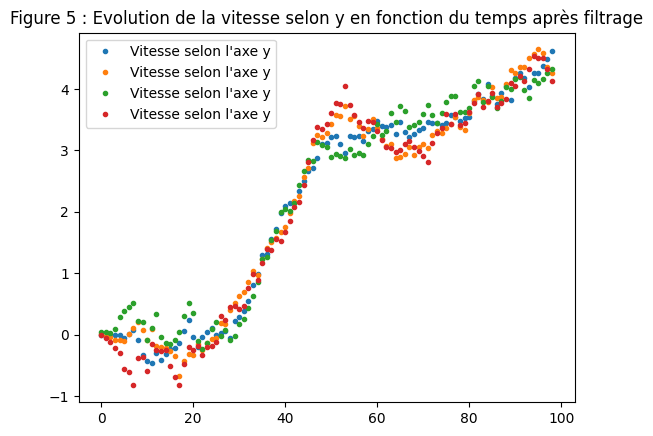

In [18]:
plt.plot(P4_corr, '.', label="Vitesse selon l'axe y")
plt.title("Figure 5 : Evolution de la vitesse selon y en fonction du temps après filtrage")
plt.legend()
plt.show()

In [19]:
def state_system2(t):
    W = state_system(t)
    A = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
    mean = [0, 0, 1, -1]
    cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
    # x prediction before 
    X_b = [0]
    # x prediction after
    X_a = [np.random.multivariate_normal(mean, cov, 1).T]
    K = [A[0:2]]
    C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    P_b = [A]
    P_a = [A]
    R = [[4, 0], [0, 4]]
    Q = [[(dt**3)/3, 0, (dt**2)/2, 0], [0, (dt**3)/3, 0, (dt**2)/2], [(dt**2)/2, 0, dt, 0], [0, (dt**2)/2, 0, dt]]
    for i in range(1, t):
        P_b.append(np.dot(np.dot(A, P_a[i-1]), A.T) + Q)
        K.append(np.dot(np.dot(P_b[i], C.T), np.linalg.inv(np.dot(np.dot(C, P_b[i]), C.T) + R)))
        # Prediction :
        X_b.append(np.dot(A, X_a[i-1]))
        P_a.append(np.dot((cov-np.dot(K[i], C)), P_b[i]))
        # Correction :
        X_a.append(X_b[i] + np.dot(K[i], W[i][0:2] + np.random.multivariate_normal(mean, cov, 1) - X_b[i][0:2]))
    return X_a, P_a

### Smooth Kalman filter

Dans cette partie on s'intéresse à une autre version du filtre de Kalman qui prend en compte la back propagation de l'algorithme pour estimer plus efficacement et avec plus de précision la sortie du modèle.

In [20]:
N=99
# Initialization for X and P correction smooth
X_cor_s = [[0, 0, 0, 0] for i in range(N)]
P_cor_s = np.zeros((4,4))

Ps = list()
for k in range(N-1, -1, -1):
    #correction smooth
    if k == N-1:
        X_cor_s[k] = Xe[k]
        P_cor_s = Pc
    else:
        xp=np.dot(A,Xe[k])
        pp=np.dot(A,np.dot(Pc,A.T))+Q
        G = np.dot(Pc, np.dot(A.T, np.linalg.inv(pp)))
        X_cor_s[k] = Xe[k] + np.dot(G, (X_cor_s[k+1] -xp))
        pp = np.dot(A,np.dot(Pc,A.T))+Q
        P_cor_s = Pc + np.dot(G, np.dot((P_cor_s - pp), G.T))
    Ps.append(P_cor_s)
    
Ps = np.array(Ps)

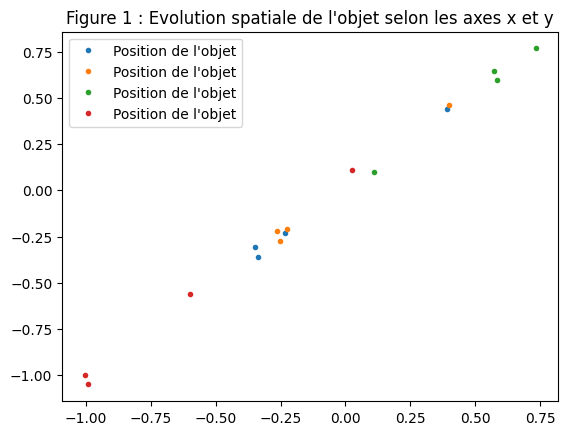

In [21]:
plt.plot(X_cor_s[0], X_cor_s[1], '.', label="Position de l'objet")
plt.title("Figure 1 : Evolution spatiale de l'objet selon les axes x et y")
plt.legend()
plt.show()

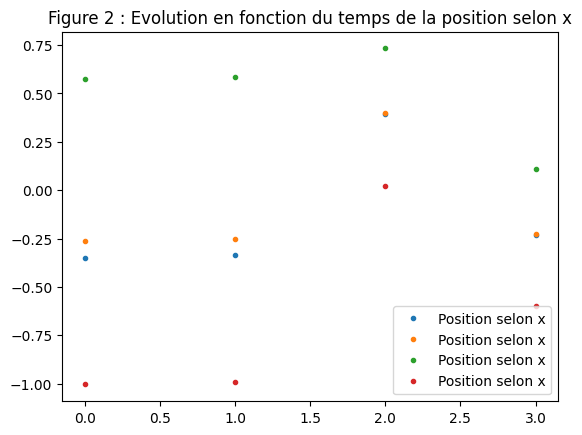

In [22]:
plt.plot(X_cor_s[0], '.', label='Position selon x')
plt.title("Figure 2 : Evolution en fonction du temps de la position selon x")
plt.legend()
plt.show()

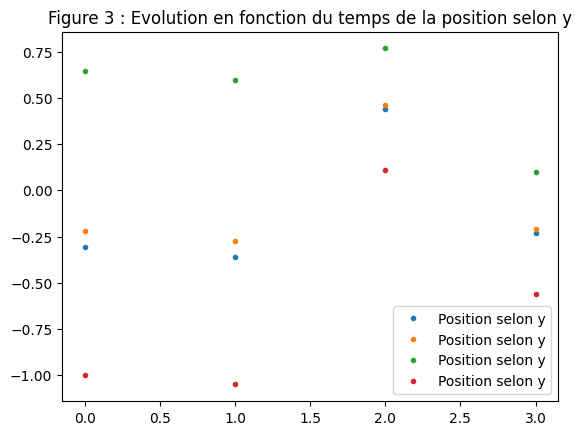

In [23]:
plt.plot(X_cor_s[1], '.', label='Position selon y')
plt.title("Figure 3 : Evolution en fonction du temps de la position selon y")
plt.legend()
plt.show()

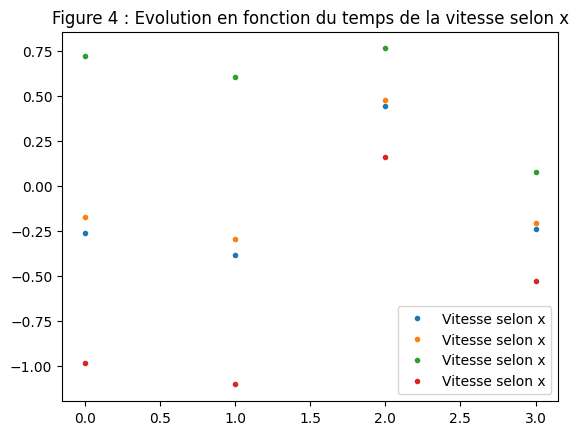

In [24]:
plt.plot(X_cor_s[2], '.', label='Vitesse selon x')
plt.title("Figure 4 : Evolution en fonction du temps de la vitesse selon x")
plt.legend()
plt.show()

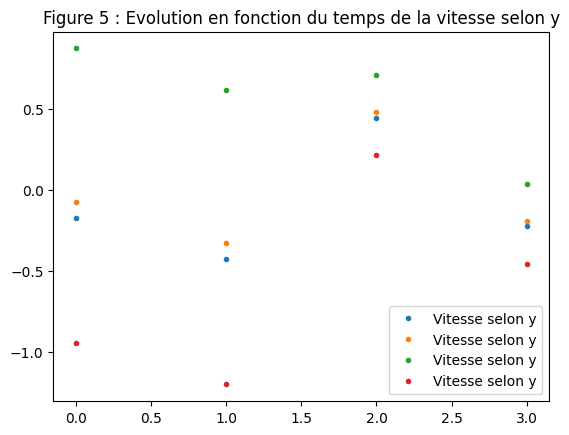

In [25]:
plt.plot(X_cor_s[4], '.', label='Vitesse selon y')
plt.title("Figure 5 : Evolution en fonction du temps de la vitesse selon y")
plt.legend()
plt.show()